### Importing Libraries

In [272]:
from encoder_model import EncoderDNN
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score
import torch as torch
import torch.nn as nn

import data_helper_413 as DataHelper
import model_413 as Model

os.environ["CUDA_VISIBLE_DEVICES"]='0'
from keras.backend.tensorflow_backend import set_session
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.9
set_session(tf.Session(config=config))




# test_csv_path=os.path.join(base_dir,'/home/aries/413/CNNLoc-Access/TestData.csv')
# valid_csv_path=os.path.join(base_dir,'/home/aries/413/BSSID_CNNLOC/CNNLoc-Access/ValidationData.csv')
# train_csv_path=os.path.join(base_dir,'/home/aries/413/BSSID_CNNLOC/CNNLoc-Access/TrainingData.csv')

In [314]:
class NN(object):

    def __init__(self):
        self.normalize_valid_x= None
        self.normalize_x= None
        self.normalize_y= None
        self.normalize_valid_y= None

    def _preprocess(self, x, y, valid_x, valid_y, data_helper):
        #self.normY = data_helper_413.NormY()
        self.normalize_x = data_helper.normalizeX(x)
        self.normalize_valid_x = data_helper.normalizeX(valid_x)

        data_helper.normY.fit(y[:, 0], y[:, 1])
        self.longitude_normalize_y, self.latitude_normalize_y = data_helper.normY.normalizeY(y[:, 0], y[:, 1])
        self.floorID_y = y[:, 2]
        self.buildingID_y = y[:, 3]

        self.longitude_normalize_valid_y, self.latitude_normalize_valid_y = data_helper.normY.normalizeY(valid_y[:, 0],valid_y[:, 1])
        self.floorID_valid_y = valid_y[:, 2]
        self.buildingID_valid_y = valid_y[:, 3]

In [652]:
# test_csv_path='UTSIndoorLoc/UTS_test.csv'
# valid_csv_path='UTSIndoorLoc/UTS_test.csv'
# train_csv_path='UTSIndoorLoc/UTS_training.csv'

test_csv_path='UJIndoorLoc/validationData.csv'
valid_csv_path='UJIndoorLoc/validationData.csv'
train_csv_path='UJIndoorLoc/validationData.csv'

# test_csv_path='TestData.csv'
# valid_csv_path='ValidationData.csv'
# train_csv_path='TrainingData.csv'

data_helper = DataHelper.DataHelper()
# data_helper.set_config(wap_size=589,long=589,lat=590,floor=591,building_id=592) # UTSIndoorLoc
# data_helper.set_config(wap_size=301,long=301,lat=302,floor=303,building_id=304) # Self-collected
data_helper.set_config(wap_size=520,long=520,lat=521,floor=522,building_id=523) # UJIIndoorLoc
(train_x, train_y), (valid_x, valid_y),(test_x,test_y) = data_helper.load_data_all(train_csv_path, valid_csv_path,test_csv_path)

# (train_x,train_y) = Model.filter_building(train_x,train_y,1)
# (valid_x, valid_y) = Model.filter_building(valid_x, valid_y,1)
nn_model = NN()
nn_model._preprocess(train_x,train_y,valid_x,valid_y,data_helper)

wap_size = nn_model.normalize_x.shape[1]
print("Number of WAPs: " + str(wap_size))

Number of WAPs: 520


### Preprocessing
We preprocess the data, first by normalizing it, then we split it into a signal strength matrix and rank matrix, which is the input into the embedding. The rank matrix takes the indices of the WAPs and sorts them via the magnitude of the signal strength.

In [653]:
def preprocess_data(data, match_length=0):
    # Initialize lists to store the preprocessed indices and signal strengths
    preprocessed_indices = []
    preprocessed_strengths = []

    # Iterate over each sample in the batch
    for sample in data:
        # Find the indices and values of non-zero signal strengths
        non_zero_indices = np.nonzero(sample)[0]
        non_zero_values = sample[non_zero_indices]

        # Sort the indices by signal strength in descending order
        sorted_indices = non_zero_indices[np.argsort(-non_zero_values)]
        sorted_values = non_zero_values[np.argsort(-non_zero_values)]

        # Append the sorted indices and values to the preprocessed data
        preprocessed_indices.append(sorted_indices)
        preprocessed_strengths.append(sorted_values)

    # Determine the maximum number of non-zero values in a sample
    M = max(len(indices) for indices in preprocessed_indices)
    
    if match_length > 0:
        M = match_length

    # Pad each list of indices and signal strengths to have the same length
    for i in range(len(preprocessed_indices)):
        padding = M - len(preprocessed_indices[i])
        preprocessed_indices[i] = np.pad(preprocessed_indices[i], (0, padding), 'constant')
        preprocessed_strengths[i] = np.pad(preprocessed_strengths[i], (0, padding), 'constant')

    # Stack the preprocessed data to form the final output
    preprocessed_indices = np.stack(preprocessed_indices)
    preprocessed_strengths = np.stack(preprocessed_strengths)

    return preprocessed_indices, preprocessed_strengths

### Model
This model uses an embedding layer as the first layer

In [654]:
from torch.nn.init import kaiming_uniform_, xavier_uniform_, xavier_normal_

class LocalizationModel(nn.Module):
    def __init__(self, num_waps, embedding_dim, hidden_dim, output_dim, dropout_rate=0):
        super(LocalizationModel, self).__init__()
        self.embedding = nn.Embedding(num_waps, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        kaiming_uniform_(self.embedding.weight.data)

    def forward(self, x, signal_strengths):
        # x is of shape (batch_size, M), where M is the maximum number of non-zero signal strengths in a sample
        # signal_strengths is of shape (batch_size, M), corresponding to the signal strengths of the WAPs in x

        # Embed the WAP indices
        x = self.embedding(x)  # shape: (batch_size, M, embedding_dim)

        # Multiply the embeddings by the signal strengths
        x = x * signal_strengths.unsqueeze(-1)  # shape: (batch_size, M, embedding_dim)

        # Sum across the signal strength dimension to get a single vector for each sample
        x = nn.ReLU()(x.sum(dim=1))  # shape: (batch_size, embedding_dim)

        # Pass through the first fully connected layer
        x = self.fc1(x)  # shape: (batch_size, hidden_dim)

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Apply dropout
        x = self.dropout(x)

        # Pass through the second fully connected layer to get the output
        out = self.fc2(x)  # shape: (batch_size, output_dim)

        return out

### Training
First we build the DataLoaders from the seperated input data as well as the target values. Then we run the training algorithm for the NN.

In [655]:
from torch.utils.data import TensorDataset, DataLoader

# Preprocess the data
pre_x, pre_strengths = preprocess_data(nn_model.normalize_x)
pre_valid_x, pre_valid_strengths = preprocess_data(nn_model.normalize_valid_x, match_length=pre_x.shape[1])
pre_y = nn_model.floorID_y
pre_valid_y = nn_model.floorID_valid_y

print(pre_x.shape, pre_strengths.shape, pre_y.shape)

# Convert the preprocessed data to PyTorch tensors
pre_y = np.vstack(pre_y).astype(np.long)
pre_valid_y = np.vstack(pre_valid_y).astype(np.long)

# Offset floors to account for basements
offset = pre_y.min() 
print(offset)
pre_y -= offset
pre_valid_y -= offset
num_classes = pre_y.max() + 1

# Convert the datasets to PyTorch tensors
pre_x = torch.tensor(pre_x, dtype=torch.long)
pre_strengths = torch.tensor(pre_strengths, dtype=torch.float32)
pre_valid_x = torch.tensor(pre_valid_x, dtype=torch.long)
pre_valid_strengths = torch.tensor(pre_valid_strengths, dtype=torch.float32)
# pre_y = torch.tensor(pre_y, dtype=torch.long)
# pre_valid_y = torch.tensor(pre_valid_y, dtype=torch.long)
pre_y = torch.tensor(pre_y.T[0], dtype=torch.long)
pre_valid_y = torch.tensor(pre_valid_y.T[0], dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(pre_x, pre_strengths, pre_y)
valid_dataset = TensorDataset(pre_valid_x, pre_valid_strengths, pre_valid_y)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)
print(pre_x.shape, pre_strengths.shape, pre_y.shape)

# Save the width of the input
input_size = pre_x.shape[1]

(1111, 35) (1111, 35) (1111,)
0
torch.Size([1111, 35]) torch.Size([1111, 35]) torch.Size([1111])


In [656]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print(torch.cuda.get_arch_list())


def train_emb_model(model, num_epochs, learning_rate, weight_decay=0.0):

    # Define the loss function and optimizer
    criterion = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_correct, total = 0, 0, 0
        model.train()
        for i, (inputs, signal_strengths, targets) in enumerate(train_loader):
            inputs, signal_strengths, targets = inputs.to(device), signal_strengths.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, signal_strengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_correct / total)

        # Validation
        val_loss, val_correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, signal_strengths, targets) in enumerate(val_loader):
                inputs, signal_strengths, targets = inputs.to(device), signal_strengths.to(device), targets.to(device)

                outputs = model(inputs, signal_strengths)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / total)

        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accs, val_accs


['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']


Epoch: 1, Train Loss: 1.5902, Train Acc: 0.3924, Val Loss: 1.5702, Val Acc: 0.4158
Epoch: 2, Train Loss: 1.5450, Train Acc: 0.4158, Val Loss: 1.5260, Val Acc: 0.4158
Epoch: 3, Train Loss: 1.4905, Train Acc: 0.4158, Val Loss: 1.4658, Val Acc: 0.4158
Epoch: 4, Train Loss: 1.4208, Train Acc: 0.4158, Val Loss: 1.3897, Val Acc: 0.4158
Epoch: 5, Train Loss: 1.3350, Train Acc: 0.4158, Val Loss: 1.3125, Val Acc: 0.4158
Epoch: 6, Train Loss: 1.2491, Train Acc: 0.4158, Val Loss: 1.2396, Val Acc: 0.4158
Epoch: 7, Train Loss: 1.1811, Train Acc: 0.4158, Val Loss: 1.1598, Val Acc: 0.4176
Epoch: 8, Train Loss: 1.0895, Train Acc: 0.4887, Val Loss: 1.0643, Val Acc: 0.5815
Epoch: 9, Train Loss: 0.9989, Train Acc: 0.6283, Val Loss: 0.9595, Val Acc: 0.6571
Epoch: 10, Train Loss: 0.8906, Train Acc: 0.6697, Val Loss: 0.8565, Val Acc: 0.6931
Epoch: 11, Train Loss: 0.7855, Train Acc: 0.7111, Val Loss: 0.7620, Val Acc: 0.7444
Epoch: 12, Train Loss: 0.7033, Train Acc: 0.7741, Val Loss: 0.6796, Val Acc: 0.7939
E

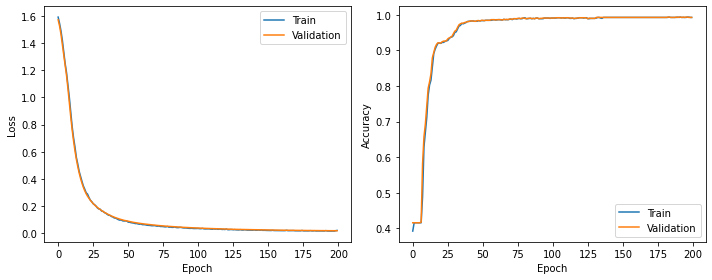

(LocalizationModel(
   (embedding): Embedding(520, 200)
   (fc1): Linear(in_features=200, out_features=200, bias=True)
   (dropout): Dropout(p=0, inplace=False)
   (fc2): Linear(in_features=200, out_features=5, bias=True)
 ),
 [1.590231266286638,
  1.5450337065590753,
  1.4905090663168166,
  1.4207676119274564,
  1.3350486026869879,
  1.249119735426373,
  1.1811290582021077,
  1.0894986026816897,
  0.9988778829574585,
  0.8905626899666257,
  0.7854871220058866,
  0.7033207052283816,
  0.6361406147480011,
  0.5592977388037575,
  0.5107020768854353,
  0.4565334767103195,
  0.41837292744053733,
  0.38288987014028764,
  0.3489040666156345,
  0.3252308525972896,
  0.2990991100668907,
  0.2885891877942615,
  0.26409705728292465,
  0.24458133429288864,
  0.23346610367298126,
  0.2182699226670795,
  0.21115021697349018,
  0.2014777229891883,
  0.18765757357080778,
  0.17978480292691124,
  0.1781041899489032,
  0.1643150651620494,
  0.16260811396771008,
  0.15308548799819416,
  0.14879833327399

In [657]:
# Create the model
embedding_dim = 200
hidden_dim = 200
# num_classes = 6

model = LocalizationModel(wap_size, embedding_dim, hidden_dim, num_classes).to(device)
train_emb_model(model, num_epochs=200, learning_rate=0.0005)

### Cosine Similarity
We can analyze the cosine similarity by displaying the top 5 WAPs with the highest cosine similarity.

In [658]:
from torch.nn.functional import cosine_similarity

def print_top_five_similar_waps(model):
    # Get the embeddings from the model
    embeddings = model.embedding.weight.data

    # Iterate over each WAP
    for i in range(embeddings.shape[0]):
        # Compute the cosine similarity with all other WAPs
        similarities = cosine_similarity(embeddings[i].unsqueeze(0), embeddings)

        # Get the indices of the top five most similar WAPs
        top_five_indices = similarities.topk(6)[1]

        # Remove the WAP itself from the list
        top_five_indices = top_five_indices[top_five_indices != i]

        # Print the WAP and its top five most similar WAPs
        print(f'WAP {i+1}:', ', '.join(f'WAP {j+1} (similarity: {similarities[j]:.4f})' for j in top_five_indices))

print_top_five_similar_waps(model)

WAP 1: WAP 43 (similarity: 0.4640), WAP 165 (similarity: 0.4467), WAP 55 (similarity: 0.4312), WAP 442 (similarity: 0.4310), WAP 169 (similarity: 0.4095)
WAP 2: WAP 258 (similarity: 0.1785), WAP 211 (similarity: 0.1694), WAP 480 (similarity: 0.1662), WAP 402 (similarity: 0.1440), WAP 470 (similarity: 0.1429)
WAP 3: WAP 128 (similarity: 0.4419), WAP 442 (similarity: 0.4255), WAP 127 (similarity: 0.4109), WAP 265 (similarity: 0.4097), WAP 55 (similarity: 0.4071)
WAP 4: WAP 305 (similarity: 0.4791), WAP 44 (similarity: 0.4618), WAP 442 (similarity: 0.4460), WAP 55 (similarity: 0.4180), WAP 128 (similarity: 0.4077)
WAP 5: WAP 410 (similarity: 0.1943), WAP 352 (similarity: 0.1638), WAP 432 (similarity: 0.1573), WAP 347 (similarity: 0.1466), WAP 342 (similarity: 0.1404)
WAP 6: WAP 471 (similarity: 0.2106), WAP 461 (similarity: 0.1707), WAP 111 (similarity: 0.1701), WAP 419 (similarity: 0.1669), WAP 403 (similarity: 0.1515)
WAP 7: WAP 269 (similarity: 0.2131), WAP 1 (similarity: 0.1762), WAP 

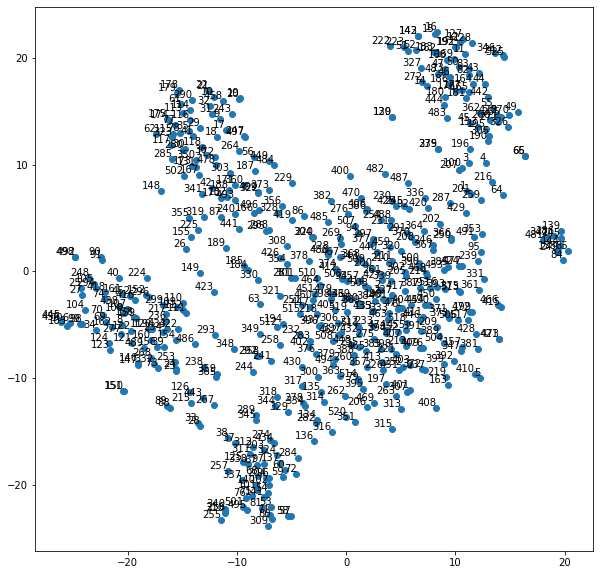

In [659]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(model):
    # Get the embeddings from the model
    embeddings = model.embedding.weight.data.cpu().numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, coords in enumerate(embeddings_2d):
        plt.text(coords[0], coords[1], str(i+1), verticalalignment='bottom', horizontalalignment='right')
    plt.show()

visualize_embeddings(model)

### Fully Connected
We train another fully connected model for reference

Epoch: 1, Train Loss: 1.5911, Train Acc: 0.2754, Val Loss: 1.5655, Val Acc: 0.2754
Epoch: 2, Train Loss: 1.5308, Train Acc: 0.3825, Val Loss: 1.4993, Val Acc: 0.4158
Epoch: 3, Train Loss: 1.4501, Train Acc: 0.4158, Val Loss: 1.4177, Val Acc: 0.4158
Epoch: 4, Train Loss: 1.3837, Train Acc: 0.4158, Val Loss: 1.3767, Val Acc: 0.4158
Epoch: 5, Train Loss: 1.3391, Train Acc: 0.4158, Val Loss: 1.3454, Val Acc: 0.4158
Epoch: 6, Train Loss: 1.3097, Train Acc: 0.4158, Val Loss: 1.3138, Val Acc: 0.4158
Epoch: 7, Train Loss: 1.2763, Train Acc: 0.4158, Val Loss: 1.2721, Val Acc: 0.4158
Epoch: 8, Train Loss: 1.2391, Train Acc: 0.4158, Val Loss: 1.2152, Val Acc: 0.4158
Epoch: 9, Train Loss: 1.1587, Train Acc: 0.4221, Val Loss: 1.1421, Val Acc: 0.4320
Epoch: 10, Train Loss: 1.0901, Train Acc: 0.4563, Val Loss: 1.0575, Val Acc: 0.4977
Epoch: 11, Train Loss: 0.9966, Train Acc: 0.5482, Val Loss: 0.9682, Val Acc: 0.5851
Epoch: 12, Train Loss: 0.9093, Train Acc: 0.6544, Val Loss: 0.8795, Val Acc: 0.7174
E

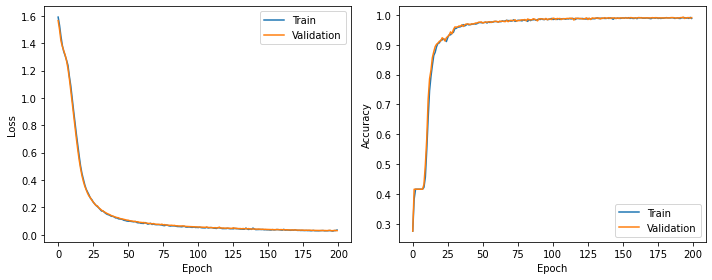

(FullyConnectedModel(
   (fc1): Linear(in_features=520, out_features=200, bias=True)
   (fc2): Linear(in_features=200, out_features=200, bias=True)
   (fc3): Linear(in_features=200, out_features=5, bias=True)
 ),
 [1.591101672914293,
  1.5308192438549466,
  1.4501492182413738,
  1.3837258881992764,
  1.339090473122067,
  1.3096948597166274,
  1.2763200137350295,
  1.2391205694940355,
  1.1586947639783223,
  1.0901377962695227,
  0.9966031908988953,
  0.9093096918529935,
  0.8214811815155877,
  0.7360223531723022,
  0.6553746230072446,
  0.5765924122598436,
  0.5028630842765173,
  0.4474095453818639,
  0.4066290772623486,
  0.36538231207264793,
  0.33314109841982525,
  0.3124941388765971,
  0.29184484316243064,
  0.2678081476026111,
  0.25737580905358,
  0.23863771226671007,
  0.22667011453045738,
  0.215303679721223,
  0.20606693045960534,
  0.19680527390705216,
  0.18539265626006657,
  0.17325053550302982,
  0.17387696107228598,
  0.16382273617717955,
  0.15565062190095583,
  0.149256

In [660]:
# Define the device
device = torch.device('cpu')

class FullyConnectedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        out = self.fc3(x)
        return out
    
# Reshape the data
pre_x = nn_model.normalize_x
pre_valid_x = nn_model.normalize_valid_x

# Convert the datasets to PyTorch tensors
pre_x_flat = torch.tensor(pre_x, dtype=torch.float32)
pre_valid_x_flat = torch.tensor(pre_valid_x, dtype=torch.float32)

# Create TensorDatasets
train_dataset_flat = TensorDataset(pre_x_flat, pre_y)
valid_dataset_flat = TensorDataset(pre_valid_x_flat, pre_valid_y)

# Create DataLoaders
train_loader_flat = DataLoader(train_dataset_flat, batch_size=batch_size, shuffle=True)
val_loader_flat = DataLoader(valid_dataset_flat, batch_size=batch_size)

def train_model(model, num_epochs, learning_rate):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        # Training
        train_loss, train_correct, total = 0, 0, 0
        model.train()
        for i, (inputs, targets) in enumerate(train_loader_flat):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_losses.append(train_loss / len(train_loader_flat))
        train_accs.append(train_correct / total)

        # Validation
        val_loss, val_correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(val_loader_flat):
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_losses.append(val_loss / len(val_loader_flat))
        val_accs.append(val_correct / total)

        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accs, val_accs

model = FullyConnectedModel(wap_size, hidden_dim, num_classes).to(device)
train_model(model, num_epochs=200, learning_rate=0.0005)

### CBOWAP

In [661]:
def to_bow_waps(data, strengths, target, window_size=2):
    res = []
    for i in range(len(data) - window_size + 1):
        if data[i+window_size-1] == 0:
            break
        res.append([data[i:i+window_size], strengths[i:i+window_size], target])
    return res

# Preprocess the data
pre_x, pre_strengths = preprocess_data(nn_model.normalize_x)
pre_valid_x, pre_valid_strengths = preprocess_data(nn_model.normalize_valid_x)
pre_y = nn_model.floorID_y
pre_valid_y = nn_model.floorID_valid_y

# Convert the preprocessed data to PyTorch tensors
pre_y = np.vstack(pre_y).astype(np.long)
pre_valid_y = np.vstack(pre_valid_y).astype(np.long)

# Offset floors to account for basements
offset = pre_y.min() 
pre_y -= offset
pre_valid_y -= offset
num_classes = pre_y.max() + 1

# Convert the data to bag of WAPs format
window_size = 3
bow_waps_data = [to_bow_waps(x, s, y, window_size) for x, s, y in zip(pre_x, pre_strengths, pre_y)]

# Flatten the data
bow_waps_data = [item for sublist in bow_waps_data for item in sublist]

# Separate the WAP indices, signal strengths, and targets
bow_waps_indices = [item[0] for item in bow_waps_data]
bow_waps_strengths = [item[1] for item in bow_waps_data]
bow_waps_targets = [item[2] for item in bow_waps_data]

# Convert the datasets to PyTorch tensors
bow_waps_indices = torch.tensor(bow_waps_indices, dtype=torch.long)
bow_waps_strengths = torch.tensor(bow_waps_strengths, dtype=torch.float32)
bow_waps_targets = torch.tensor(bow_waps_targets, dtype=torch.long).T[0]
pre_valid_x = torch.tensor(pre_valid_x, dtype=torch.long)
pre_valid_strengths = torch.tensor(pre_valid_strengths, dtype=torch.float32)
pre_valid_y = torch.tensor(pre_valid_y, dtype=torch.long).T[0]

# Create TensorDatasets
train_dataset = TensorDataset(bow_waps_indices, bow_waps_strengths, bow_waps_targets)
valid_dataset = TensorDataset(pre_valid_x, pre_valid_strengths, pre_valid_y)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)

please ignore training accuracies
Epoch: 1, Train Loss: 1.4099, Train Acc: 0.3950, Val Loss: 1.2714, Val Acc: 0.4158
Epoch: 2, Train Loss: 1.2945, Train Acc: 0.4243, Val Loss: 1.0660, Val Acc: 0.5185
Epoch: 3, Train Loss: 1.2398, Train Acc: 0.4628, Val Loss: 0.7667, Val Acc: 0.6526
Epoch: 4, Train Loss: 1.1636, Train Acc: 0.5061, Val Loss: 0.5362, Val Acc: 0.8020
Epoch: 5, Train Loss: 1.0990, Train Acc: 0.5334, Val Loss: 0.3896, Val Acc: 0.8668
Epoch: 6, Train Loss: 1.0575, Train Acc: 0.5534, Val Loss: 0.3170, Val Acc: 0.9010
Epoch: 7, Train Loss: 1.0325, Train Acc: 0.5642, Val Loss: 0.2844, Val Acc: 0.9118
Epoch: 8, Train Loss: 1.0179, Train Acc: 0.5677, Val Loss: 0.2526, Val Acc: 0.9109
Epoch: 9, Train Loss: 1.0048, Train Acc: 0.5720, Val Loss: 0.2395, Val Acc: 0.9154
Epoch: 10, Train Loss: 0.9949, Train Acc: 0.5760, Val Loss: 0.2232, Val Acc: 0.9091
Epoch: 11, Train Loss: 0.9859, Train Acc: 0.5810, Val Loss: 0.2110, Val Acc: 0.9316
Epoch: 12, Train Loss: 0.9790, Train Acc: 0.5828, V

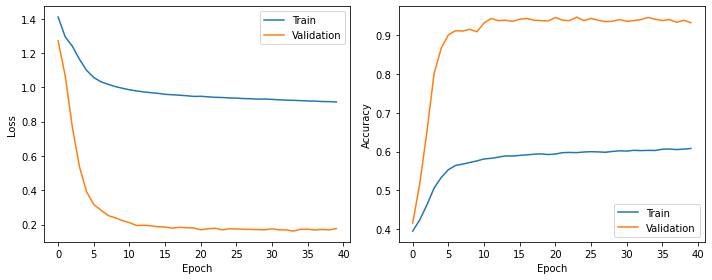

(LocalizationModel(
   (embedding): Embedding(520, 200)
   (fc1): Linear(in_features=200, out_features=200, bias=True)
   (dropout): Dropout(p=0, inplace=False)
   (fc2): Linear(in_features=200, out_features=5, bias=True)
 ),
 [1.409850059954588,
  1.2945348689378786,
  1.2398106793234172,
  1.1635973020033403,
  1.0990339295923217,
  1.057518396003187,
  1.0325212091946405,
  1.0178818323395469,
  1.0048178471316975,
  0.9949450406653821,
  0.9859392687308887,
  0.978988973069782,
  0.9735352488096095,
  0.9690365025327226,
  0.9650720887440295,
  0.9595679155558594,
  0.9569493120859477,
  0.9542436506137375,
  0.9514257247782936,
  0.9472477386805637,
  0.9479681218951201,
  0.9447801635285055,
  0.9419978522072153,
  0.9408002303651541,
  0.9382127646572334,
  0.9373403711259858,
  0.9346480872020249,
  0.9337134811996428,
  0.931397690507006,
  0.9318421798304093,
  0.929974689956539,
  0.9272362624318147,
  0.9254182008179751,
  0.9243633466318619,
  0.9225140117909297,
  0.92080

In [663]:
embedding_dim = 200
hidden_dim = 200

model = LocalizationModel(wap_size, embedding_dim, hidden_dim, num_classes).to(device)
print("please ignore training accuracies")
train_emb_model(model, num_epochs=40, learning_rate=0.0005, weight_decay=0.0001)

### Convolutional Model

In [664]:
class CNNModel(nn.Module):
    def __init__(self, num_waps, embedding_dim, hidden_dim, output_dim):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(num_waps, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.fc = nn.Linear(hidden_dim, output_dim)

        kaiming_uniform_(self.embedding.weight.data)

    def forward(self, x, signal_strengths):
        # x is of shape (batch_size, M), where M is the maximum number of non-zero signal strengths in a sample
        # signal_strengths is of shape (batch_size, M), corresponding to the signal strengths of the WAPs in x

        # Embed the WAP indices
        x = self.embedding(x)  # shape: (batch_size, M, embedding_dim)

        # Multiply the embeddings by the signal strengths
        x = x * signal_strengths.unsqueeze(-1)  # shape: (batch_size, M, embedding_dim)

        # Transpose the tensor to match the input shape requirement of nn.Conv1d
        x = x.transpose(1, 2)  # shape: (batch_size, embedding_dim, M)

        # Pass through the first convolutional layer
        x = self.conv1(x)  # shape: (batch_size, hidden_dim, M)

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Pass through the second convolutional layer
        x = self.conv2(x)  # shape: (batch_size, hidden_dim, M)

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Sum across the signal strength dimension to get a single vector for each sample
        x = x.sum(dim=2)  # shape: (batch_size, hidden_dim)

        # Pass through the fully connected layer to get the output
        out = self.fc(x)  # shape: (batch_size, output_dim)

        return out
    
    

Epoch: 1, Train Loss: 1.3438, Train Acc: 0.4205, Val Loss: 6.9361, Val Acc: 0.4158
Epoch: 2, Train Loss: 1.2086, Train Acc: 0.4855, Val Loss: 4.5558, Val Acc: 0.5266
Epoch: 3, Train Loss: 1.1107, Train Acc: 0.5350, Val Loss: 5.4232, Val Acc: 0.4851
Epoch: 4, Train Loss: 1.0693, Train Acc: 0.5488, Val Loss: 4.6954, Val Acc: 0.5365
Epoch: 5, Train Loss: 1.0227, Train Acc: 0.5648, Val Loss: 3.1100, Val Acc: 0.5806
Epoch: 6, Train Loss: 0.9781, Train Acc: 0.5824, Val Loss: 2.9518, Val Acc: 0.6283
Epoch: 7, Train Loss: 0.9568, Train Acc: 0.5894, Val Loss: 3.3010, Val Acc: 0.7048
Epoch: 8, Train Loss: 0.9495, Train Acc: 0.5935, Val Loss: 2.4531, Val Acc: 0.6175
Epoch: 9, Train Loss: 0.9384, Train Acc: 0.5953, Val Loss: 3.2036, Val Acc: 0.5887
Epoch: 10, Train Loss: 0.9354, Train Acc: 0.5971, Val Loss: 2.2289, Val Acc: 0.6346
Epoch: 11, Train Loss: 0.9308, Train Acc: 0.5974, Val Loss: 2.8195, Val Acc: 0.6373
Epoch: 12, Train Loss: 0.9299, Train Acc: 0.5992, Val Loss: 2.9788, Val Acc: 0.5977
E

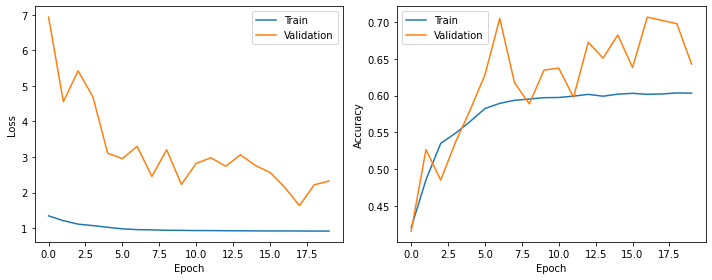

(CNNModel(
   (embedding): Embedding(520, 200)
   (conv1): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
   (conv2): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
   (fc): Linear(in_features=200, out_features=5, bias=True)
 ),
 [1.343787477036153,
  1.2085757895934681,
  1.1107119031188901,
  1.0692767269355206,
  1.02272386122341,
  0.9780741245293421,
  0.9568202071938633,
  0.9495363109860538,
  0.938407798443944,
  0.9354115702396582,
  0.9307619311100195,
  0.9299366011107264,
  0.9254884128728189,
  0.9245218538548335,
  0.9204685101824358,
  0.9193601352124174,
  0.9193310252398499,
  0.9171076328301233,
  0.9153671040515269,
  0.9151236419835367],
 [6.936087105009291,
  4.555793199274275,
  5.423174851470524,
  4.695398509502411,
  3.1100267701678805,
  2.951836778057946,
  3.301048379805353,
  2.4530524942609997,
  3.2036229769388833,
  2.228894723786248,
  2.8195375170972614,
  2.978759672906664,
  2.7391108638710446,
  3.0628657042980194,
  2.76541760067145,
  2.56625308

In [665]:
embedding_dim = 200
hidden_dim = 200

model = CNNModel(wap_size, embedding_dim, hidden_dim, num_classes).to(device)
train_emb_model(model, num_epochs=20, learning_rate=0.0005, weight_decay=0.0001)

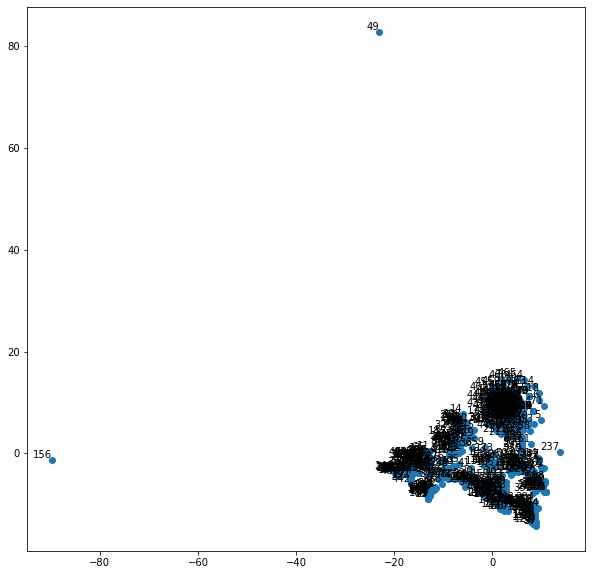

In [666]:
visualize_embeddings(model)

### Regression

In [667]:
# Preprocess the data
pre_x, pre_strengths = preprocess_data(nn_model.normalize_x)
pre_valid_x, pre_valid_strengths = preprocess_data(nn_model.normalize_valid_x, match_length=pre_x.shape[1])

print(pre_x.shape, pre_strengths.shape, pre_valid_x.shape, pre_valid_strengths.shape)

# Convert the preprocessed data to PyTorch tensors
pre_longitude_y = np.vstack(nn_model.longitude_normalize_y).astype(np.float32)
pre_latitude_y = np.vstack(nn_model.latitude_normalize_y).astype(np.float32)
pre_longitude_valid_y = np.vstack(nn_model.longitude_normalize_valid_y).astype(np.float32)
pre_latitude_valid_y = np.vstack(nn_model.latitude_normalize_valid_y).astype(np.float32)

# Convert the datasets to PyTorch tensors
pre_x = torch.tensor(pre_x, dtype=torch.long)
pre_strengths = torch.tensor(pre_strengths, dtype=torch.float32)
pre_valid_x = torch.tensor(pre_valid_x, dtype=torch.long)
pre_valid_strengths = torch.tensor(pre_valid_strengths, dtype=torch.float32)
pre_longitude_y = torch.tensor(pre_longitude_y.T[0], dtype=torch.float32)
pre_latitude_y = torch.tensor(pre_latitude_y.T[0], dtype=torch.float32)
pre_longitude_valid_y = torch.tensor(pre_longitude_valid_y.T[0], dtype=torch.float32)
pre_latitude_valid_y = torch.tensor(pre_latitude_valid_y.T[0], dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(pre_x, pre_strengths, pre_longitude_y, pre_latitude_y)
valid_dataset = TensorDataset(pre_valid_x, pre_valid_strengths, pre_longitude_valid_y, pre_latitude_valid_y)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)

print(pre_x.shape, pre_strengths.shape, pre_longitude_y.shape, pre_latitude_y.shape)

(1111, 35) (1111, 35) (1111, 35) (1111, 35)
torch.Size([1111, 35]) torch.Size([1111, 35]) torch.Size([1111]) torch.Size([1111])


In [668]:
from torch.nn.init import kaiming_uniform_, xavier_uniform_, xavier_normal_

class LongModel(nn.Module):
    def __init__(self, num_waps, embedding_dim, hidden_dim, dropout_rate):
        super(LongModel, self).__init__()
        self.embedding = nn.Embedding(num_waps, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

        kaiming_uniform_(self.embedding.weight.data)

    def forward(self, x, signal_strengths):
        # Embed the WAP indices
        x = self.embedding(x)  

        # Multiply the embeddings by the signal strengths
        x = x * signal_strengths.unsqueeze(-1)  

        # Sum across the signal strength dimension to get a single vector for each sample
        x = x = nn.ReLU()(x.sum(dim=1))  

        # Pass through the first fully connected layer
        x = self.fc1(x)  

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Apply dropout
        x = self.dropout(x)

        # Pass through the second fully connected layer to get the output
        out = self.fc2(x)  

        return out

In [669]:
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print(torch.cuda.get_arch_list())

def train_reg_model(model, num_epochs, learning_rate, weight_decay=0.0):
    # Define the loss function and optimizer
    criterion = MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 regularization

    # Initialize lists to store losses for training and validation
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training
        train_loss = 0
        model.train()
        for i, (inputs, signal_strengths, longitude_targets, latitude_targets) in enumerate(train_loader):
            inputs, signal_strengths, longitude_targets, latitude_targets = inputs.to(device), signal_strengths.to(device), longitude_targets.to(device), latitude_targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, signal_strengths)
            loss = criterion(outputs, torch.stack((longitude_targets, latitude_targets), dim=1))
            # loss = criterion(outputs, longitude_targets)
            criterion = MSELoss()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, signal_strengths, longitude_targets, latitude_targets) in enumerate(val_loader):
                inputs, signal_strengths, longitude_targets, latitude_targets = inputs.to(device), signal_strengths.to(device), longitude_targets.to(device), latitude_targets.to(device)

                outputs = model(inputs, signal_strengths)
                loss = criterion(outputs, torch.stack((longitude_targets, latitude_targets), dim=1))
                # loss = criterion(outputs, longitude_targets)

                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']


Epoch: 1, Train Loss: 0.1140, Val Loss: 0.0497
Epoch: 2, Train Loss: 0.0283, Val Loss: 0.0186
Epoch: 3, Train Loss: 0.0156, Val Loss: 0.0126
Epoch: 4, Train Loss: 0.0110, Val Loss: 0.0094
Epoch: 5, Train Loss: 0.0078, Val Loss: 0.0068
Epoch: 6, Train Loss: 0.0057, Val Loss: 0.0049
Epoch: 7, Train Loss: 0.0041, Val Loss: 0.0038
Epoch: 8, Train Loss: 0.0033, Val Loss: 0.0030
Epoch: 9, Train Loss: 0.0025, Val Loss: 0.0025
Epoch: 10, Train Loss: 0.0021, Val Loss: 0.0022
Epoch: 11, Train Loss: 0.0020, Val Loss: 0.0019
Epoch: 12, Train Loss: 0.0016, Val Loss: 0.0019
Epoch: 13, Train Loss: 0.0015, Val Loss: 0.0016
Epoch: 14, Train Loss: 0.0014, Val Loss: 0.0018
Epoch: 15, Train Loss: 0.0013, Val Loss: 0.0014
Epoch: 16, Train Loss: 0.0012, Val Loss: 0.0013
Epoch: 17, Train Loss: 0.0010, Val Loss: 0.0013
Epoch: 18, Train Loss: 0.0010, Val Loss: 0.0011
Epoch: 19, Train Loss: 0.0009, Val Loss: 0.0011
Epoch: 20, Train Loss: 0.0009, Val Loss: 0.0010
Epoch: 21, Train Loss: 0.0008, Val Loss: 0.0010
E

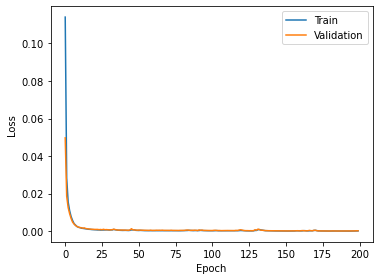

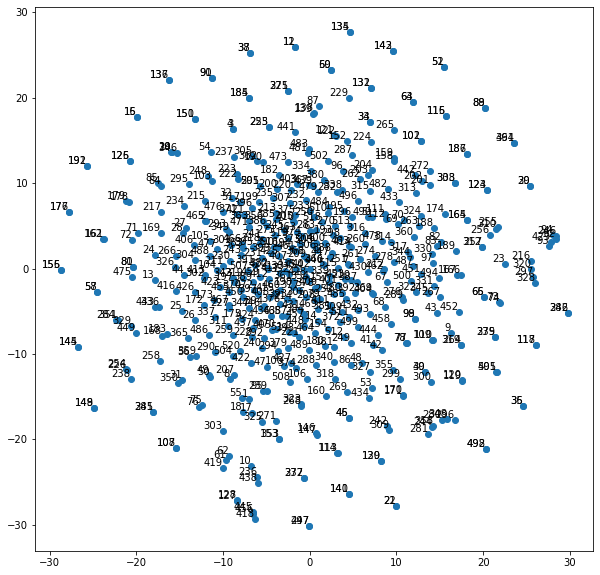

In [672]:
model = LongModel(wap_size, embedding_dim, hidden_dim, dropout_rate=0).to(device)
train_reg_model(model, num_epochs=200, learning_rate=0.005, weight_decay=0.000)
visualize_embeddings(model)

/home/aries/miniconda3/envs/CNNLOC/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


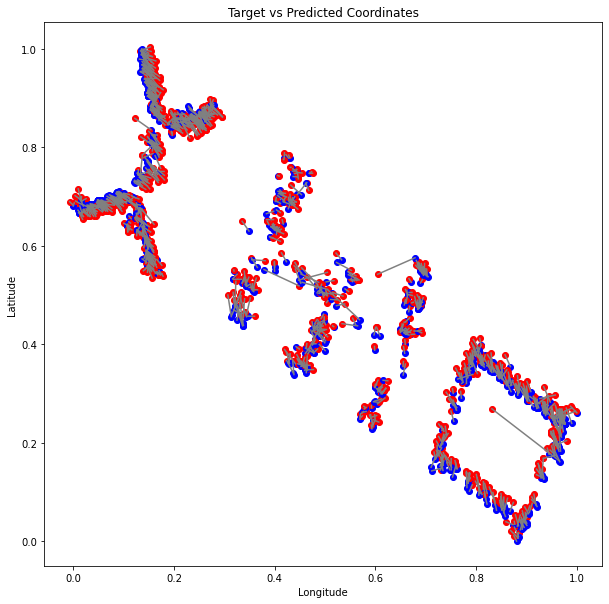

1110 tensor([0.0174])


In [673]:
val_exam_loader = DataLoader(valid_dataset, batch_size=1)
sum = 0

model.eval()
plt.figure(figsize=(10, 10))

with torch.no_grad():
    for i, (inputs, signal_strengths, longitude_targets, latitude_targets) in enumerate(val_exam_loader):
        inputs, signal_strengths, longitude_targets, latitude_targets = inputs.to(device), signal_strengths.to(device), longitude_targets.to(device), latitude_targets.to(device)

        outputs = model(inputs, signal_strengths)
        sum += np.sqrt((longitude_targets - outputs[0][0]) ** 2 + (latitude_targets -  outputs[0][1]) ** 2)
        # print((longitude_targets, latitude_targets), outputs, np.sqrt((longitude_targets - outputs[0][0]) ** 2 + (latitude_targets -  outputs[0][1]) ** 2))

        # Plot the target and predicted coordinates
        plt.scatter(longitude_targets.cpu().numpy(), latitude_targets.cpu().numpy(), color='blue')  # target
        plt.scatter(outputs[0][0].cpu().numpy(), outputs[0][1].cpu().numpy(), color='red')  # prediction

        # Draw a line between the target and predicted coordinates
        plt.plot([longitude_targets.cpu().numpy(), outputs[0][0].cpu().numpy()], [latitude_targets.cpu().numpy(), outputs[0][1].cpu().numpy()], color='gray')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Target vs Predicted Coordinates')
plt.show()

print(i, sum / i)


### Regression w/ FC

torch.Size([1111, 520]) torch.Size([1111]) torch.Size([1111])
Epoch: 1, Train Loss: 0.2249, Val Loss: 0.1240
Epoch: 2, Train Loss: 0.0891, Val Loss: 0.0829
Epoch: 3, Train Loss: 0.0740, Val Loss: 0.0682
Epoch: 4, Train Loss: 0.0569, Val Loss: 0.0461
Epoch: 5, Train Loss: 0.0315, Val Loss: 0.0218
Epoch: 6, Train Loss: 0.0177, Val Loss: 0.0158
Epoch: 7, Train Loss: 0.0140, Val Loss: 0.0134
Epoch: 8, Train Loss: 0.0120, Val Loss: 0.0118
Epoch: 9, Train Loss: 0.0106, Val Loss: 0.0105
Epoch: 10, Train Loss: 0.0094, Val Loss: 0.0094
Epoch: 11, Train Loss: 0.0086, Val Loss: 0.0088
Epoch: 12, Train Loss: 0.0082, Val Loss: 0.0077
Epoch: 13, Train Loss: 0.0072, Val Loss: 0.0073
Epoch: 14, Train Loss: 0.0063, Val Loss: 0.0065
Epoch: 15, Train Loss: 0.0057, Val Loss: 0.0059
Epoch: 16, Train Loss: 0.0054, Val Loss: 0.0055
Epoch: 17, Train Loss: 0.0048, Val Loss: 0.0051
Epoch: 18, Train Loss: 0.0046, Val Loss: 0.0047
Epoch: 19, Train Loss: 0.0040, Val Loss: 0.0045
Epoch: 20, Train Loss: 0.0040, Val 

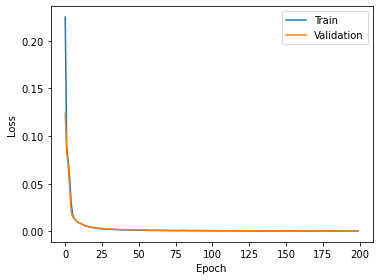

(LongModel(
   (fc1): Linear(in_features=520, out_features=200, bias=True)
   (dropout): Dropout(p=0.0, inplace=False)
   (fc2): Linear(in_features=200, out_features=200, bias=True)
   (fc3): Linear(in_features=200, out_features=2, bias=True)
 ),
 [0.22485369278324974,
  0.08909653623898824,
  0.07395495784779389,
  0.056926668932040535,
  0.031546845100820065,
  0.017717930850469403,
  0.014024315867573023,
  0.011993414644772807,
  0.010596677583331863,
  0.00938627079853581,
  0.008581620873883367,
  0.008188429236825969,
  0.0071906413779490525,
  0.00634678163462215,
  0.005706035014655855,
  0.00537448742478672,
  0.004798169086118125,
  0.004625174359211491,
  0.004047183313458744,
  0.003950719204213884,
  0.0037083799640337625,
  0.003367350385006931,
  0.003096775032140108,
  0.003054638102184981,
  0.002891663578338921,
  0.002921225962280813,
  0.002787571031755457,
  0.0024697178547891476,
  0.002322333392738882,
  0.0022076318548190305,
  0.0021356427071926496,
  0.002352

In [674]:
from torch.nn.init import kaiming_uniform_, xavier_uniform_, xavier_normal_

class LongModel(nn.Module):
    def __init__(self, num_waps, hidden_dim, dropout_rate):
        super(LongModel, self).__init__()
        self.fc1 = nn.Linear(num_waps, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)

    def forward(self, x, signal_strengths):
        # Embed the WAP indices
        x = self.fc1(x)  

        # Multiply the embeddings by the signal strengths
        # x = x * signal_strengths.unsqueeze(-1)  

        x = nn.ReLU()(x)

        # Sum across the signal strength dimension to get a single vector for each sample
        # x = x.sum(dim=1)  

        # Pass through the first fully connected layer
        x = self.fc2(x)  

        # Apply a ReLU activation function
        x = nn.ReLU()(x)

        # Apply dropout
        x = self.dropout(x)

        # Pass through the second fully connected layer to get the output
        out = self.fc3(x)  

        return out
    
pre_x = nn_model.normalize_x
pre_valid_x = nn_model.normalize_valid_x

# Convert the preprocessed data to PyTorch tensors
pre_longitude_y = np.vstack(nn_model.longitude_normalize_y).astype(np.float32)
pre_latitude_y = np.vstack(nn_model.latitude_normalize_y).astype(np.float32)
pre_longitude_valid_y = np.vstack(nn_model.longitude_normalize_valid_y).astype(np.float32)
pre_latitude_valid_y = np.vstack(nn_model.latitude_normalize_valid_y).astype(np.float32)

# Convert the datasets to PyTorch tensors
pre_x = torch.tensor(pre_x, dtype=torch.float32)
pre_valid_x = torch.tensor(pre_valid_x, dtype=torch.float32)
pre_longitude_y = torch.tensor(pre_longitude_y.T[0], dtype=torch.float32)
pre_latitude_y = torch.tensor(pre_latitude_y.T[0], dtype=torch.float32)
pre_longitude_valid_y = torch.tensor(pre_longitude_valid_y.T[0], dtype=torch.float32)
pre_latitude_valid_y = torch.tensor(pre_latitude_valid_y.T[0], dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(pre_x, pre_strengths, pre_longitude_y, pre_latitude_y)
valid_dataset = TensorDataset(pre_valid_x, pre_valid_strengths, pre_longitude_valid_y, pre_latitude_valid_y)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)

print(pre_x.shape, pre_longitude_y.shape, pre_latitude_y.shape)

model = LongModel(wap_size, hidden_dim, dropout_rate=0.0).to(device)
train_reg_model(model, num_epochs=200, learning_rate=0.001, weight_decay=0.000)